# Разработка стратегии взаимодействия с пользователями сети фитнес-центров на основе аналитических данных

Предсказание оттока пользователей с использованием данных о пользовании услугами фитнес-клуба за последний месяц

1. [Подготовка данных](#step1)
2. [Исследовательский анализ данных (EDA)](#step2)
3. [Модель прогнозирования оттока пользователей](#step3)
4. [Кластеризация пользователей](#step4)
5. [Выводы и рекомендации](#step5)

## Подготовка данных  <a name="step1"></a>

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, accuracy_score, precision_score, recall_score, roc_auc_score

from sklearn.cluster import KMeans

from scipy.cluster.hierarchy import dendrogram, linkage

In [2]:
data = pd.read_csv('/datasets/gym_churn.csv')
display(data.head())

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [3]:
#уберем заглавные буквы из названий столбцов
data = data.rename(columns=lambda x: str.lower(x))

In [4]:
#общая информация о датасете
display(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
near_location                        4000 non-null int64
partner                              4000 non-null int64
promo_friends                        4000 non-null int64
phone                                4000 non-null int64
contract_period                      4000 non-null int64
group_visits                         4000 non-null int64
age                                  4000 non-null int64
avg_additional_charges_total         4000 non-null float64
month_to_end_contract                4000 non-null float64
lifetime                             4000 non-null int64
avg_class_frequency_total            4000 non-null float64
avg_class_frequency_current_month    4000 non-null float64
churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


None

In [5]:
data.duplicated().sum()

0

Пропущенных значений и дубликатов нет

### Выводы

Данные загружены, название столбцов приведены к нижнему регистру, пропущенных значений нет

## Исследовательский анализ данных (EDA) <a name="step2"></a>

In [6]:
#описательная статистика для датасета
data.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
near_location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


Пользователи примерно поровну распределены по полу, большинство работает или живет рядом с клубом. Около половины пользователей являются сотрудниками компаний-партнеров, треть использовали промокод "приведи друга", то есть их друзья или родственники тоже являются клиентами. Групповые занятия посещают около 40%. Примерно половина пользователей имеет короткий контракт (1 мес), годовые контракты заключают меньше четверти клиентов. Возраст клиентов от 18 до 41, медиана 29 лет. Медианное время от первого обращения в клуб 3 месяца (максимум 31 месяц). Половина пользователей посещает клуб меньше 2 раз в неделю (медиана 1.8)

In [7]:
#рассчитаем долю клиентов, попавших в отток, чтобы дальше использовать для оценки вероятности
churn = data['churn'].mean()
print('Доля клиентов, попавших в отток: {:.2f}'.format(churn))

Доля клиентов, попавших в отток: 0.27


In [8]:
#средние значения признаков в двух группах - тех, кто ушел в отток и тех, кто остался, и относительная разница между значениями 
data.\
    groupby('churn').\
    mean().\
    T.\
    assign(delta_percent = lambda x: abs((x[0] - x[1]) / x[0] )).\
    round(2).\
    style.\
    background_gradient(cmap='YlGn', 
                        subset = 'delta_percent',
                        high = 0.5)

churn,0,1,delta_percent
gender,0.51,0.51,0
near_location,0.87,0.77,0.12
partner,0.53,0.36,0.33
promo_friends,0.35,0.18,0.48
phone,0.9,0.9,0
contract_period,5.75,1.73,0.7
group_visits,0.46,0.27,0.42
age,29.98,26.99,0.1
avg_additional_charges_total,158.45,115.08,0.27
month_to_end_contract,5.28,1.66,0.69


Наибольшая разница между средними значениями в группах наблюдается по признакам `lifetime`, `contract_period`, `month_to_end_contract`. То есть наиболее значимыми параметрами являются время с момента первого обращения в фитнес-центр, длительность контракта и количество месяцев до окончания контракта. Разницы между группами по полу и наличию контактного телефона нет.


 Гистограммы для всех признаков с делением на группы по факту оттока


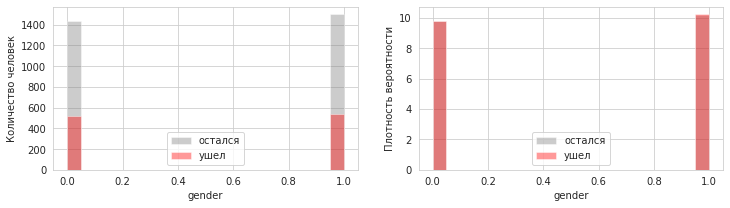

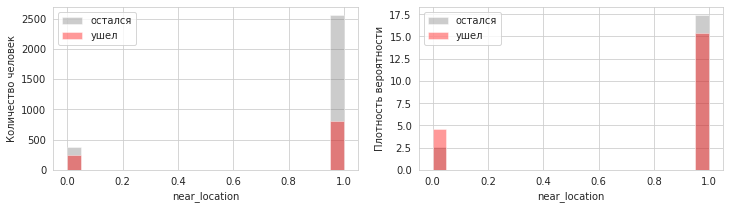

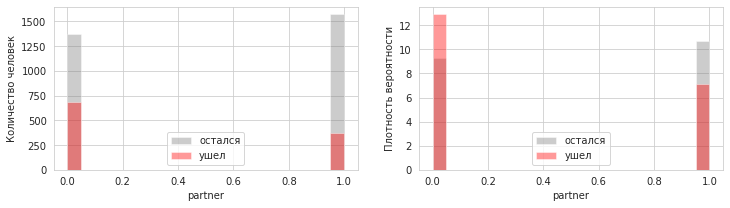

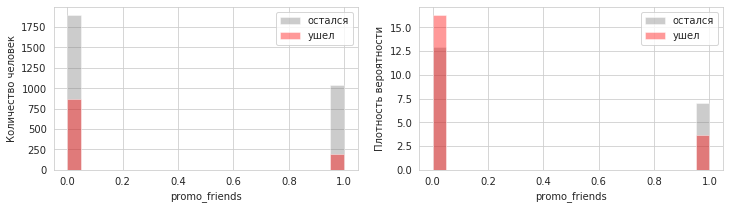

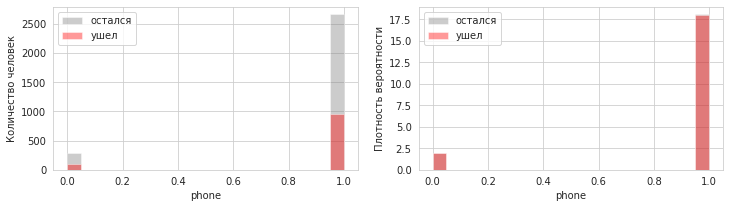

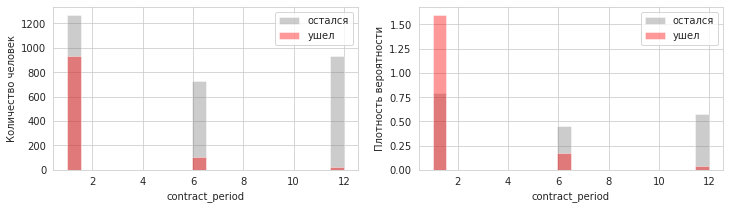

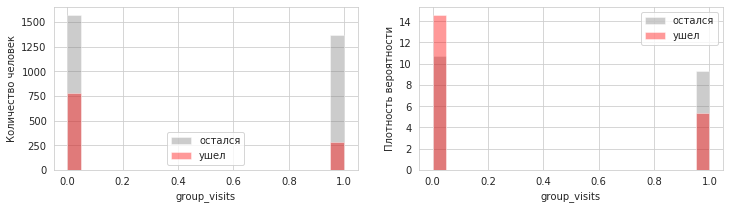

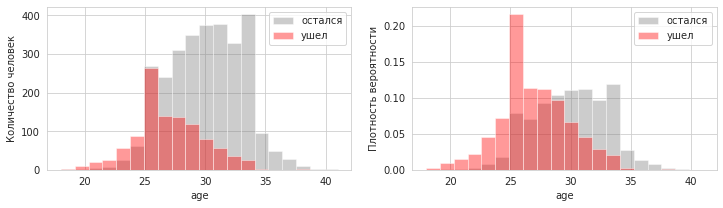

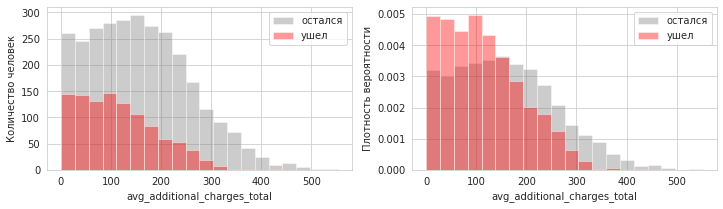

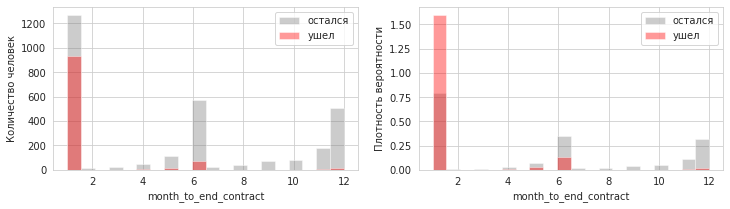

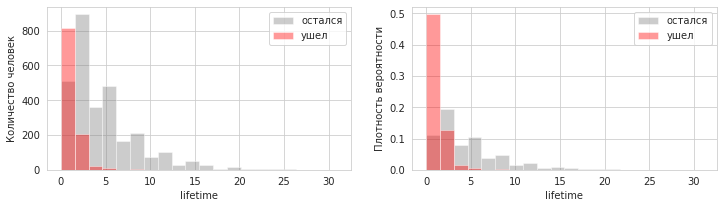

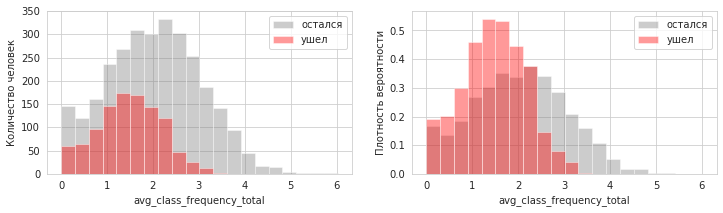

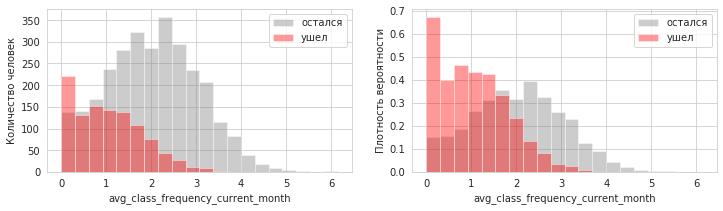

In [9]:
sns.set_style("whitegrid")
print('\n Гистограммы для всех признаков с делением на группы по факту оттока')
hist_ranges = {}

for column in data.columns:
    if column != 'churn':
        hist_range = (data[column].min(), data[column].max())
        fig, ax = plt.subplots(1,2, figsize = (12,3))
        sns.distplot(data[data['churn'] == 0][column], 
                     kde=False, 
                     bins=20, 
                     norm_hist = True, 
                     label = 'остался', 
                     ax = ax[1],
                     color = 'grey',
                     hist_kws = {'range':hist_range}
                    )
        sns.distplot(data[data['churn'] == 1][column], 
                     kde=False, 
                     bins=20, 
                     norm_hist = True, 
                     label = 'ушел', 
                     ax = ax[1], 
                     color = 'r',
                     hist_kws = {'range':hist_range})
        sns.distplot(data[data['churn'] == 0][column], 
                     kde=False, 
                     bins=20, 
                     label = 'остался', 
                     ax = ax[0],
                     color = 'grey',
                     hist_kws = {'range':hist_range})
        sns.distplot(data[data['churn'] == 1][column], 
                     kde=False, 
                     bins=20, 
                     label = 'ушел', 
                     ax = ax[0],
                     color = 'r',
                     hist_kws = {'range':hist_range})
        ax[0].set_ylabel('Количество человек')
        ax[1].set_ylabel('Плотность вероятности')
        ax[0].legend()
        ax[1].legend()
        plt.show()

Cравнение гистограмм для двух групп показывает, что есть признаки, которые не отличаются между группами: пол `'gender'` и наличие контактного телефона `'phone'`. Для остальных признаков визуально можно определить различия в форме распределений, то есть наблюдается разница в значениях параметров между группами, и эти признаки можно использовать для предсказания поведения клиентов.
Пользователи, которые не попали в отток, а остались клиентами фитнес-клуба:
* чаще живут или работают в районе, где расположен клуб
* чаще являются сотрудниками компаний-партнеров клуба
* чаще используют промокод "приведи друга" при регистрации, то есть кто-то из их знакомых так же является клиентом
* заключают более длительные контракты
* посещают групповые занятия
* в среднем старше
* тратят больше на дополнительные услуги клуба
* имеют больше срок до окончания текущего контракта (что скорее всего связано с большей длительностью самого контракта)
* их время с момента первого обращения в клуб больше
* чаще посещали клуб за последний месяц и за все время с начала действия абонемента

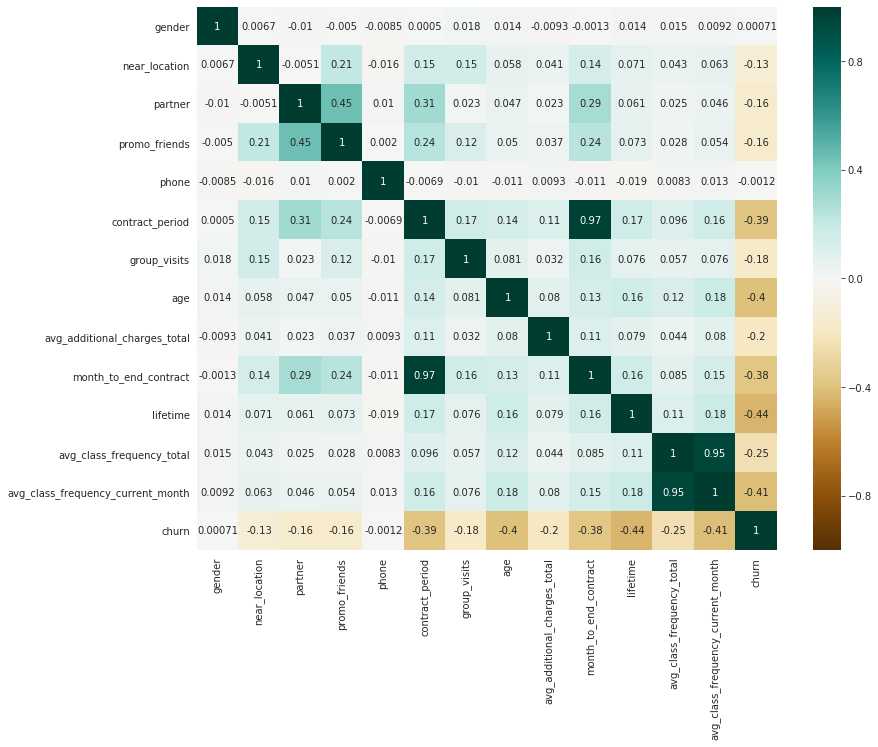

In [10]:
#визуализация матрицы коррелляции
fig, ax = plt.subplots(figsize=(13,10))
sns.heatmap(data.corr(), annot = True, cmap = 'BrBG', vmin=-1);

Среди признаков есть две пары сильно коррелирующих:
* `'Month_to_end_contract'` срок до окончания текущего действующего абонемента (в месяцах) и `'Contract_period'` длительность текущего действующего абонемента (r = 0.97)

* `'Avg_class_frequency_current_month'` средняя частота посещений в неделю за предыдущий месяц и `'Avg_class_frequency_total'`  средняя частота посещений в неделю за все время с начала действия абонемента (r = 0.95)

Эти признаки действительно логически связаны и не являются независимыми

Признаков, сильно корреллирующих в целевой переменной (факт оттока) нет

### Выводы
* В отток каждый месяц попадат 27% клиентов клуба
* Ни один из признаков не коррелирует сильно с фактом оттока, то есть его вероятность определяется комбинацией факторов
* В датасете присутсвуют признаки, имеющие сильную корреляцию между собой и не являющиеся независимыми: время до окончания контракта связано с длительностью контракта, а средняя частота посещений в неделю за предыдущий месяц сильно коррелирует с значениями за все время с начала контракта
* Пол клиента и факт наличия контактного телефона не влияют на то, будет ли клиент продолжать пользоваться услугами клуба
* Клиенты, заключающие короткие контракты, живущие или работающие не в районе клуба, не являющиеся сотрудниками компании-партнера скорее всего не будут долго пользоваться его услугами
* Более длительное и активное пользование как основными, так и дополнительными услугами клуба говорит о том, что клиент с меньшей вероятностью попадет в отток

## Модель прогнозирования оттока пользователей <a name="step3"></a>

In [11]:
#разделим датасет на вектор значений целевой переменной и матрицу признаков
X = data.drop(['churn'], axis=1)
y = data['churn']

# разделим данные на тестовую и валидационную выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state = 0)

In [12]:
#функции для обучения модели и расчета метрик

def train_model (model_name, X_train, y_train, X_test):
    model = model_name
    model.fit(X_train, y_train)
    probabilities = model.predict_proba(X_test)[:,1]
    return probabilities

def auc_roc(y_test, probabilities):
    return roc_auc_score(y_test, probabilities)

def accuracy(y_test, probabilities, threshold):
    predictions = [0 if i<threshold else 1 for i in probabilities]
    return accuracy_score(y_test, predictions)

def precision(y_test, probabilities, threshold):
    predictions = [0 if i<threshold else 1 for i in probabilities]
    return precision_score(y_test, predictions)

def recall(y_test, probabilities, threshold):
    predictions = [0 if i<threshold else 1 for i in probabilities]
    return recall_score(y_test, predictions)

def auc_precision_recall(y_test, probabilities):
    return average_precision_score(y_test, probabilities)

Для сравнения моделей расчитаем площадь под ROC кривой  и площадь под кривой Precision-Recall (AP - average precision). Так как в нашем наборе данных класс 0 (остались) примерно в 3 раза превышает по размеру класс 1 (попали в отток), то для оценки качества модели лучше использовать Precision-Recall, так как False Positive Rate (FPR) может быть занижен из-за большого количества True Negative (TN)

FPR = FP/(FP+TN)
TPR = TP/(TP+FN) = Recall

Так как нам важно выделить клиентов, которые попадают в отток, то для оценки качества модели лучше использовать precision  и recall, которые позволяют оценить, насколько хорошо выделяется группа 1  и не принимают во внимание количество True Negative (TN)

Precision = TP/(TP+FP)

Recall = TPR = TP/(TP+FN)

Для интегральной оценки качества моделей рассчитаем площадь под обеими кривыми

In [13]:
#Рассчитаем интегральные метрики для двух моделей

#предсказанные вероятности
probabilities = {'random_forest': 
                     train_model(RandomForestClassifier(random_state=0,n_estimators=100), X_train, y_train, X_test,),
                     'logistic_regression': 
                     train_model(LogisticRegression(solver='liblinear',random_state=0), X_train, y_train, X_test)
                }

#какие метрики применять
functions = [auc_roc,auc_precision_recall]    

#создаем таблицу для параметров
model_comparison = pd.DataFrame()

#заполняем таблицу
for i in range(len(functions)):
    model_comparison.loc[i,'score'] = functions[i].__name__
    model_comparison.loc[i,'random_forest'] = functions[i](y_test,probabilities['random_forest']).round(2)
    model_comparison.loc[i,'logistic_regression'] = functions[i](y_test,probabilities['logistic_regression']).round(2)
    

model_comparison['delta'] = (model_comparison['random_forest'] - model_comparison['logistic_regression']).apply(pd.to_numeric)

display(model_comparison)

,score,random_forest,logistic_regression,delta
0,auc_roc,0.97,0.98,-0.01
1,auc_precision_recall,0.93,0.95,-0.02


Логистическая регрессия демонстрирует немного большее значение площади под кривой Precision-Recall при примерно одинаковой площади под ROC-кривой.

Для того, чтобы определить оптимальный порог значения вероятности отнесения результата к одному из классов, рассчитаем максимальное значение (TPR - FPR) по значениям ROC-кривой для каждой из моделей. Так как у нас нет данных по прибыли и убыткам, которые являются результатом ошибок и правильной классификации, то будем использовать математически определенный порог. В реальности он должен выбираться из расчета потерь при неправильной классификации и прибыли при правильной.

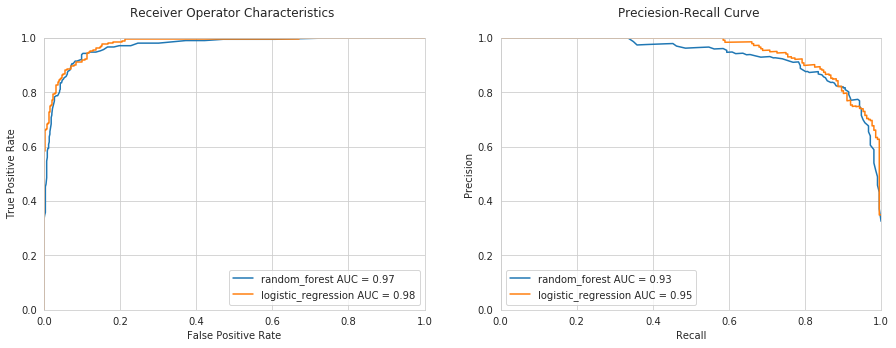

In [14]:
#Построим кривые ROC и Precision Recall
fig, ax = plt.subplots(1,2, figsize = (15,5))

ax[0].set_title('Receiver Operator Characteristics \n')
ax[1].set_title('Preciesion-Recall Curve \n')
ax[0].set_ylim(0,1)
ax[0].set_xlim(0,1)
ax[1].set_ylim(0,1)
ax[1].set_xlim(0,1)
ax[0].set_ylabel('True Positive Rate')
ax[0].set_xlabel('False Positive Rate')
ax[1].set_ylabel('Precision')
ax[1].set_xlabel('Recall')

threshold_values = {}

for key in probabilities:
    
    #рассчитаем метрики для всех значений порога
    fpr, tpr, threshold = metrics.roc_curve(y_test, probabilities[key])
    prec, rec, thresholds = precision_recall_curve(y_test, probabilities[key])
    
    #площадь под кривыми
    roc_auc = metrics.auc(fpr, tpr)
    average_precision = average_precision_score(y_test, probabilities[key])
    
    #сохраним значение порога, где значение tpr - fpr максимально
    difference = []
    zip_object = zip(tpr, fpr)
    for tpr_i, fpr_i in zip_object:
        difference.append(tpr_i-fpr_i)
    n = difference.index(max(difference))
    threshold_values[key] = threshold[n]

    #строим графики    
    ax[0].plot(fpr, tpr, label = key + ' AUC = %0.2f' % roc_auc)
    ax[1].plot(rec, prec, label = key + ' AUC = %0.2f' % average_precision)


ax[0].legend(loc = 'lower right')
ax[1].legend(loc = 'lower left')

plt.show()

Далее рассчитаем метрики accuracy, precision и recall для подобранных оптимальных порогах для каждой из моделей

In [15]:
#Рассчитаем все метрики для двух моделей для одного порогового значения

#создаем таблицу для сравниения
model_comparison = pd.DataFrame()

#какие метрики применять
functions = [accuracy,precision, recall]    

#порог для разделения групп по вероятности
threshold_value = 0.27

#заполняем таблицу
for i in range(len(functions)):
    model_comparison.loc[i,'score'] = functions[i].__name__
    model_comparison.loc[i,'random_forest'] = functions[i](y_test,probabilities['random_forest'],
                                                           threshold_values['random_forest']
                                                          )\
                                                            .round(2)
    model_comparison.loc[i,'rf_threshold'] = threshold_values['random_forest']
    model_comparison.loc[i,'logistic_regression'] = functions[i](y_test,probabilities['logistic_regression'],
                                                                 threshold_values['logistic_regression']
                                                                ).round(2)
    model_comparison.loc[i,'lg_threshold'] = threshold_values['logistic_regression']
    

model_comparison['score_delta'] = (model_comparison['random_forest'] 
                                   - model_comparison['logistic_regression']
                                  )\
                                    .apply(pd.to_numeric)

display(model_comparison)

,score,random_forest,rf_threshold,logistic_regression,lg_threshold,score_delta
0,accuracy,0.91,0.27,0.90,0.216843,0.01
1,precision,0.77,0.27,0.74,0.216843,0.03
2,recall,0.94,0.27,0.95,0.216843,-0.01


При подобранном оптимальном пороге значения метрик для двух моделей очень близки, однако соотношение precision-recall лучше для логистической регрессии. Следует провести оценку разброса значений метрик при различных делениях общей выборки на тестовую и обучающую, а также для различных значений параметров модели. Однако это выходит за рамки данного исследования.

 
 Для фитнес-клуба важно идентифицировать клиентов, которые могут уйти в отток, и предпринять какие-то целевые действия, чтобы этого избежать. Чем выше recall, тем ниже доля ложноотрицательных результатов, то есть неидентифицированных пользователей, попадающих в отток. Однако вместе с увеличением recall растет доля ложноположительных результатов, то есть клиентов, которые ошибочно идентифицированы как потенциальны отток.
    
   Чтобы удержать пользователя, можно предложить ему какие-то скидки или индивидуальные предложения. Это может принести дополнительную прибыль, если это поможет удержать клиента. Однако скидки, предложенные клиентам, которые не собирались уходить, приводят к убыткам. Поэтому для вычисления оптимального значения метрик precision и recall необходимо численно оценить потенциальные убытки и прибыль.

Посмотрим, какие из признаков оказались наиболее важными для классификации:

In [16]:
model = RandomForestClassifier(random_state=0,n_estimators=100)
model.fit(X_train, y_train)
importances = model.feature_importances_
features_table = pd.DataFrame({'features':X.columns, 'importance':importances}, columns = ['features', 'importance'])

display(features_table.
                sort_values(by = 'importance', ascending = False).
                reset_index(drop=True).
                style.
                background_gradient(cmap = 'YlGn')
        )

,features,importance
0,lifetime,0.270336
1,avg_class_frequency_current_month,0.176142
2,avg_class_frequency_total,0.135955
3,age,0.121477
4,avg_additional_charges_total,0.0883265
5,month_to_end_contract,0.0729405
6,contract_period,0.0674058
7,group_visits,0.0160902
8,gender,0.0122934
9,partner,0.0120994


Наиболее важными признаками для классификации оказались:
* время с момента первого обращения в фитнес-центр `lifetime`
* средняя частота посещений в неделю за предыдущий месяц `avg_class_frequency_current_month`
* средняя частота посещений в неделю за все время с начала действия абонемента `avg_class_frequency_total`
* возраст `age`
* суммарная выручка от других услуг фитнес-центра `avg_additional_charges_total`
* срок до окончания текущего действующего абонемента `month_to_end_contract`
* срок контракта `contract_period`

Посмотрим еще раз на таблицу отличия средних значений между группами

In [17]:
#средние значения признаков в двух группах - тех, кто ушел в отток и тех, кто остался, и относительная разница между значениями 
data.\
    groupby('churn').\
    mean().\
    T.\
    assign(delta_percent = lambda x: abs((x[0] - x[1]) / x[0] )).\
    sort_values(by = 'delta_percent', ascending = False).\
    round(2).\
    style.\
    background_gradient(cmap='YlGn', 
                        subset = 'delta_percent',
                        high = 0.5)

churn,0,1,delta_percent
lifetime,4.71,0.99,0.79
contract_period,5.75,1.73,0.7
month_to_end_contract,5.28,1.66,0.69
avg_class_frequency_current_month,2.03,1.04,0.48
promo_friends,0.35,0.18,0.48
group_visits,0.46,0.27,0.42
partner,0.53,0.36,0.33
avg_additional_charges_total,158.45,115.08,0.27
avg_class_frequency_total,2.02,1.47,0.27
near_location,0.87,0.77,0.12


Для параметра `lifetime` наблюдалась и наибольшая разница средних значений, однако дальнейший порядок важнейших признаков не соответсвует простому уменьшению разницы средних значений. То есть модель показывает более сложные взаимосвязи, чем видны при простом визуальном делении по значению признаков

### Выводы

* Модели случайного леса и логистической регресии демонстрируют близкие значения метрик качества предсказаний. Для случайного леса AUC-ROC = 0.97 Precision-Recall AUC = 0.92, для логистической регрессии AUC-ROC = 0.98 Precision-Recall AUC = 0.95

* Оптимальный порог вероятности принадлежности наблюдения к тому или иному классу был выбран по ROC кривой для каждой из моделей в точке max(TPR-FPR)

*  Для фитнес-клуба важно идентифицировать клиентов, которые могут уйти в отток, и предпринять какие-то целевые действия, чтобы этого избежать. Чем выше recall, тем ниже доля ложноотрицательных результатов, то есть неидентифицированных пользователей, попадающих в отток. Однако если стремиться увеличить только recall, то растет доля ложноположительных результатов, то есть клиентов, которые ошибочно идентифицированы как потенциальный отток. Для выбора оптимальной модели необходимо провести расчет убытков и прибыли, являющихся результатов ошибки предсказания или верной классификации 

* Наиболее важными признаками для классификации оказались:

    * время с момента первого обращения в фитнес-центр 
    * средняя частота посещений в неделю за предыдущий месяц
    * средняя частота посещений в неделю за все время с начала действия абонемента    
    * возраст 
    * суммарная выручка от других услуг фитнес-центра
    * срок до окончания текущего действующего абонемента
    * срок контракта 

## Кластеризация пользователей <a name="step4"></a>

In [18]:
#проведем стандартизацию признаков
sc = StandardScaler()
X_sc = sc.fit_transform(X)

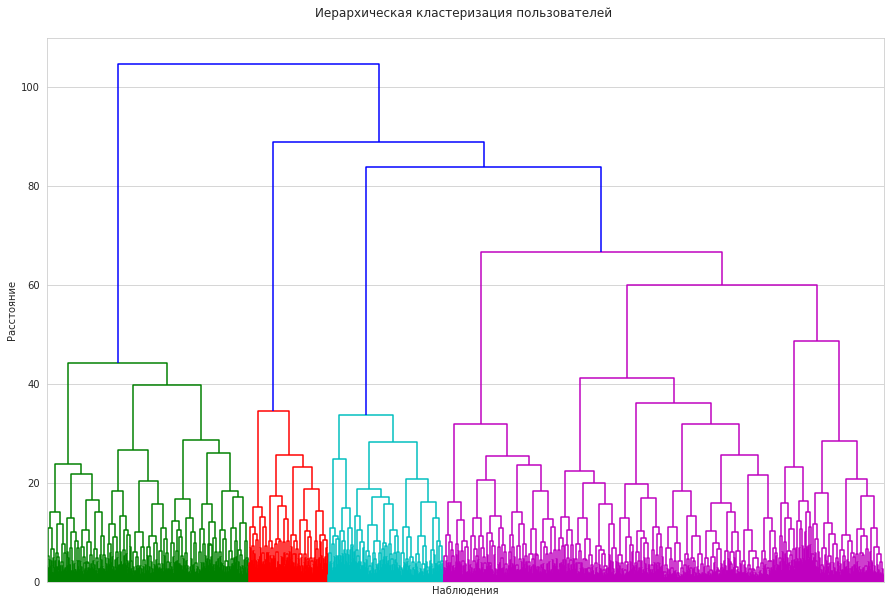

In [19]:
#проведем иерархическаю агломеративную кластеризацию
linked = linkage(X_sc, method = 'ward')

#нарисуем дендрограмму
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация пользователей \n')
plt.ylabel('Расстояние')
plt.xlabel('Наблюдения')
plt.xticks([])
plt.show()

Оптимальное число кластеров по этому алгоритму - 4

In [20]:
#присвоим названия классов после разделения
km = KMeans(n_clusters = 5, random_state = 0) # задаём число кластеров, равное 5, как указано в задании
labels = km.fit_predict(X_sc)

data['cluster_km'] = labels
X['cluster_km'] = labels
display(data.head())

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn,cluster_km
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0,1
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0,3
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0,3


In [21]:
fig, ax = plt.subplots(figsize = (20,20) ,dpi=400)
plt.suptitle('Средние значения признаков по кластерам +/- SD', fontsize = 16)
for i, column in enumerate(X.drop('cluster_km', axis=1).columns):
    plt.subplot(5, 3, i+1)
    sns.barplot(x = 'cluster_km', y = column, data = data, ci="sd" )
    plt.ylabel(column,fontsize=14 )
    plt.xlabel('cluster',fontsize=14 )
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
    

Можно отметить следующее:
* кластер 4 демонстрирует максимальную частоту посещения клуба, при коротких контрактах. Стоит заметить, что это старые клиенты, время с первого обращения максимально, скорее всего в отток они не попадут, так как давно и активно пользуются услугами клуба

* кластер 3 показывает самую низкую частоту посещения, короткие контракты и самую низкую суммарную длительность пользования. Кроме того, они в среднем младще. Возможно, именно они в основном попадают в отток: попробовали, не понравилось, ушли,  а люди склонны задумываться о здоровом образе жизни и посещать фитнес-клуб в более старшем возрасте

* пользователи кластера 0 имеют самые длительные контракты, чаще являются сотрудниками компании партнера или пользуются промокодом "приведи друга", и достаточно часто пользуются услугами клуба. Скорее всего они тоже будут продолжать пользоваться и дальше

Остальные кластеры находятся между описанными. Скорее всего, 5 слишком большое количество кластеров для корректного описания. В соответствии с K means кластеризацией, следовало выделить 4

Посмотрим на распределение количественных признаков, которые имеют разные значения в кластерах:

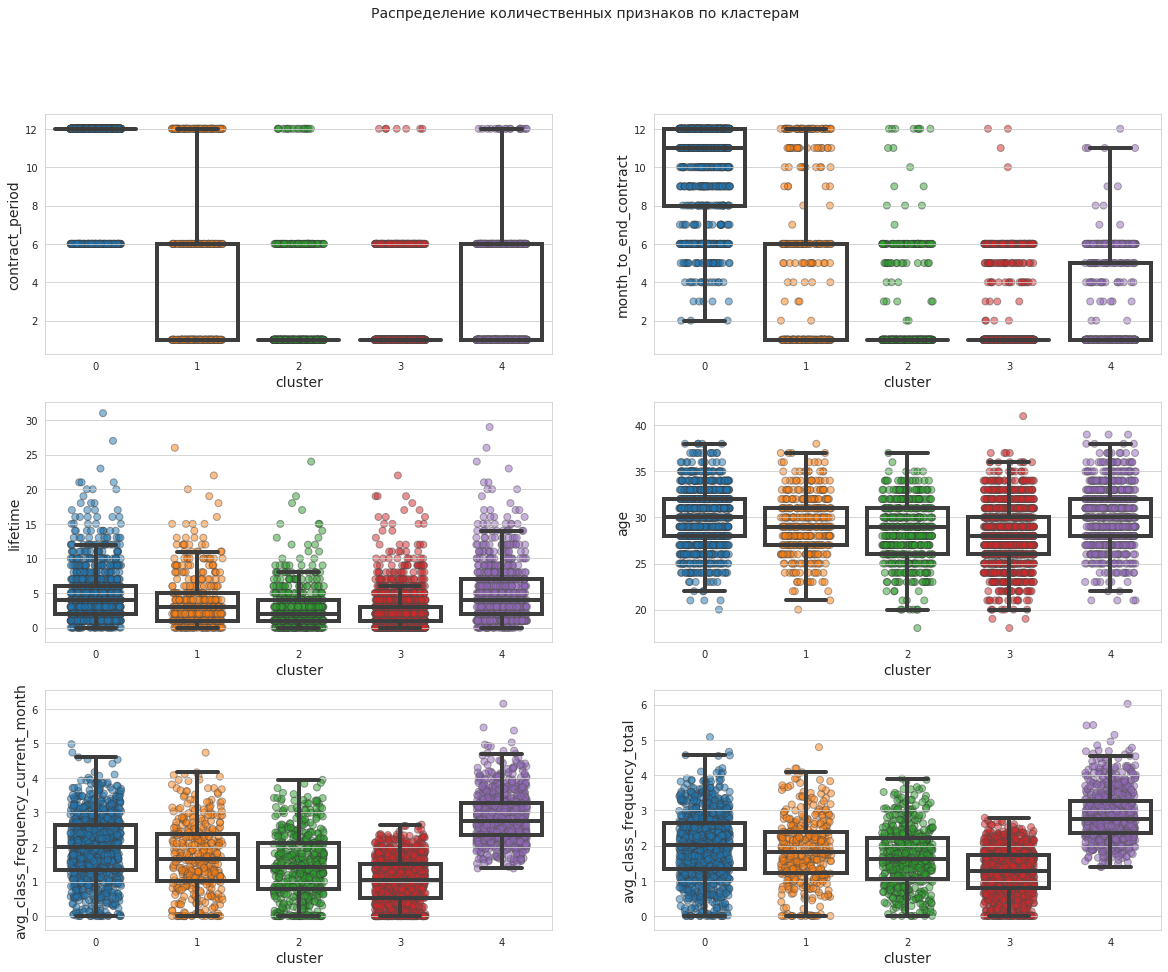

In [22]:
features = ['contract_period', 
            'month_to_end_contract', 
            'lifetime', 
            'age',
            'avg_class_frequency_current_month', 
            'avg_class_frequency_total']

cdict = dict(zip(np.unique(data['cluster_km'].sort_values().values), plt.cm.tab10.colors))

fig, ax = plt.subplots(3,2, figsize = (20,15))
plt.suptitle('Распределение количественных признаков по кластерам', fontsize = 14)
ax = ax.flatten()
for i, column in enumerate(features):
    for cluster in data['cluster_km'].sort_values().unique().tolist():
        sns.stripplot(data = data
              , x='cluster_km'
              , y = data[data['cluster_km'] == cluster][column]
              , edgecolor='gray'
              , color = cdict[cluster]
              , alpha = 0.5
              , linewidth = 1
              , size=7
              , jitter = 0.25
              , zorder=0
              , ax = ax[i]
             )
        sns.boxplot(data=data
            , x='cluster_km'
            , y=data[data['cluster_km'] == cluster][column]
            , whis=1.5
            , linewidth = 4
            , boxprops={'facecolor':'none'}
            , fliersize = 0
            , ax = ax[i]
            )
    ax[i].set_xlabel('cluster', fontsize = 14)
    ax[i].set_ylabel(column, fontsize = 14)
plt.show()
    

Распределения показывают те же закономерности, что и средние значиния: 
* кластеры 3 и 4 максимально далеко друг от друга по частоте пользования услугами
* кластер 0 имеет самые долгие контракты, не меньше 6 месяцев
* в кластере 4 нет пользователей, которые посещают клуб меньше одного раза в неделю, это самамя дисциплинированная группа

In [23]:
display(data.groupby('cluster_km')['churn'].mean().sort_values(ascending = False).reset_index())

,cluster_km,churn
0,3,0.514263
1,2,0.443564
2,1,0.267532
3,4,0.068100
4,0,0.027695


Есть два кластера (0 и 4) с минимальной долей оттока: 
* кластер 0 - группа тех, кто покупают длинные контракты, используют промокод "приведи друга" и являются сотрудниками компаний-партнеров. Они давно и стабильно пользуются услугами, их друзья и коллеги, скорее всего, тоже посещают этот клуб, также компания партнер вероятно частично оплачивает для них долгие контракты
* кластер 4 - группа пользователей, которые ходят в клуб наиболее часто, но при этом не покупают длинные контракты. Возможно для них годовой контракт слишком дорогой, поэтому они покупают более дешевые контракты, но чаще. Кроме эти клиенты пользуются услугами клуба по-максимуму, возможно из-за того, что покупка абонемента является заметной тратой, и мотивация его использовать максимально высока

Кластеры 3 и 2 наиболее склонны к оттоку

В целом, пользователи, чаще и/или дольше посещающие клуб, менее склонны попадать в отток. Этот вывод соответвует тому, что показывает важность признаков модели классификации

### Выводы

* Кластеризация пользователей позволила выделить следующие характерные группы:
 
   - кластер 4 демонстрирует максимальную частоту посещения клуба, при коротких контрактах. Стоит заметить, что это старые клиенты, время с первого обращения максимально, скорее всего в отток они не попадут, так как давно и активно пользуются услугами клуба

   - кластер 3 показывает самую низкую частоту посещения, короткие контракты и самую низкую суммарную длительность пользования. Кроме того, они в среднем младще. Возможно, именно они в основном попадают в отток: попробовали, не понравилось, ушли, а люди склонны задумываться о здоровом образе жизни и посещать фитнес-клуб в более старшем возрасте

   - пользователи кластера 0 имеют самые длительные контракты, чаще являются сотрудниками компании партнера или пользуются промокодом "приведи друга", и достаточно часто пользуются услугами клуба. Скорее всего они тоже будут продолжать пользоваться и дальше

   - остальные кластеры находятся между описанными
   
   
* При расчете доли оттока для кластеров выделяются два кластера (0 и 4) с минимальной долей оттока:

    - кластер 0 - группа тех, кто покупают длинные контракты, используют промокод "приведи друга" и являются сотрудниками компаний-партнеров. Они давно и стабильно пользуются услугами, их друзья и коллеги, скорее всего, тоже посещают этот клуб, также компания партнер вероятно частично оплачивает для них долгие контракты. Доля оттока 2.7%
    - кластер 4 - группа пользователей, которые ходят в клуб наиболее часто, но при этом не покупают длинные контракты. Возможно для них годовой контракт слишком дорогой, поэтому они покупают более дешевые контракты, но чаще. Кроме эти клиенты пользуются услугами клуба по-максимуму, возможно из-за того, что покупка абонемента является заметной тратой, и мотивация его использовать максимально высока. Доля оттока 6.8%
    - Кластеры 3 и 2 наиболее склонны к оттоку - около половину пользователей уходят

* В целом, пользователи, чаще и/или дольше посещающие клуб, менее склонны попадать в отток. Этот вывод соответвует тому, что показывает важность признаков модели классификации

* Таким образом кластеризация позволила правильно идентифицировать группы пользователей, максимально склонных не пользоваться услугами фитнес-клуба дальше. То есть их поведение можно предсказать по другим наблюдениям

## Общие выводы <a name="step5"></a>

* В отток каждый месяц попадат 27% клиентов клуба


* Ни один из признаков не коррелирует сильно с фактом оттока, то есть его вероятность определяется комбинацией факторов


* В датасете присутсвуют признаки, имеющие сильную корреляцию между собой и не являющиеся независимыми: время до окончания контракта связано с длительностью контракта, а средняя частота посещений в неделю за предыдущий месяц сильно коррелирует с значениями за все время с начала контракта


* Данные были проанализированы двумя спобобами: 

    * построена модель классификафии на основе случайного леса и логистической регрессии. Модели показали очень близкие значения метрик качества классификации (площадь под кривой Precision-Recall 0.92 и 0.95 соответственно)
    * пользователи разделены на кластеры по наблюдаемым признакам
    
    
* Наиболее важными признаками для моделей классификации оказались 

    * время с момента первого обращения в фитнес-центр
    * средняя частота посещений в неделю за предыдущий месяц
    * средняя частота посещений в неделю за все время с начала действия абонемента
    * возраст
    * суммарная выручка от других услуг фитнес-центра
    * срок до окончания текущего действующего абонемента
    * срок контракта
    
    То есть пользователи, пользующиеся услугами дольше и чаще, а также в среднем менее молодые, скорее всего не попадут в отток
    
    
* Кластеризация позволила разделить пользователей, не попадающих в отток, на две сильно различающихся группы:

    *  группа тех, кто покупают длинные контракты, используют промокод "приведи друга" и являются сотрудниками компаний-партнеров. Они давно и стабильно пользуются услугами, их друзья и коллеги, скорее всего, тоже посещают этот клуб, также компания партнер вероятно частично оплачивает для них долгие контракты. Доля оттока 2.7%
    * группа пользователей, которые ходят в клуб наиболее часто, но при этом не покупают длинные контракты. Возможно для них годовой контракт слишком дорогой, поэтому они покупают более дешевые контракты, но чаще. Кроме эти клиенты пользуются услугами клуба по-максимуму, возможно из-за того, что покупка абонемента является заметной тратой, и мотивация его использовать максимально высока. Доля оттока 6.8%
    * Доля оттока среди тах, кто показывает самую низкую частоту посещения, короткие контракты и самую низкую суммарную длительность пользования достигает 50%. Кроме того, они в среднем младше. Скорее всего, они попробовали, не понравилось, ушли.



## Рекомендации

* Необходимо рассчитать потенциальную прибыль при верной классификации пользователей на группы по оттоку и потенциальные убытки при ошибках, это позволит настроить модели классификации


* Пользователям, идентифицированным как имеющим высокий риск оттока, можно предложить дополнительные акции или скидки, чтобы их удержать. Для более старшей аудитории возможно имеет смысл напомнить о важности здорового образа жизни


* Так как чаще попадают в отток более молодые клиенты, для них может быть актуально заниматься вместе с друзьями, поэтому им можно предложить дополнительные промокоды для них
